<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


輪郭線の画素数は、左 303  右294


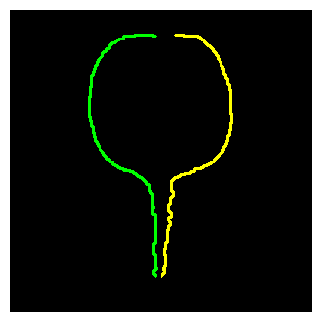

In [25]:
# 画像の左右の輪郭線を抽出　（S5参照）
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

輪郭線を構成する画素の数は、この例で左右それぞれ300画素近い。

## getSamples()
> rd.getSamples(cont,N=20,mode='Equidistant')
    # 入力
    # 　cont 輪郭線構造体 開いた輪郭線を想定している
    # 　N サンプル数
    # パラメータ
    #　 mode = 'Equidistant'なら始点からの距離について等間隔 (default)
    # 　mode = 'Simple' なら単純にインデックスを等間隔

ディジタル画像は斜め方向と上下左右とで画素間の距離が異なるので、単純にインデックスを等間隔に刻むと、輪郭が斜めになっている部分と縦横に伸びている部分とでサンプリング間隔が変化してしまう。

曲線あてはめにはそれほど影響しないが、気にする場合は Equidistantを用いるとよい。

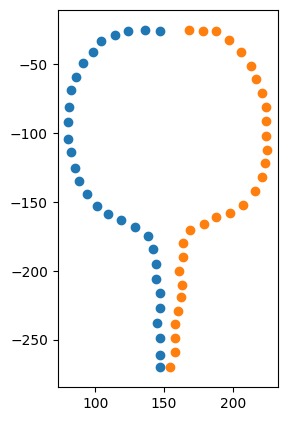

In [26]:
Left = rd.getSamples(conLeft,N=30,mode='Equidistant')
Right = rd.getSamples(conRight,N=30,mode='Simple')

plt.figure(figsize=(5,5),dpi=100)
g = plt.subplot()
g.set_aspect('equal')
plt.scatter(Left[:,0],-Left[:,1])
plt.scatter(Right[:,0],-Right[:,1]);

左が距離等間隔、右がインデックスの等間隔

# ベジエ曲線のあてはめ

- 標本点 samples[i] と同じ数だけの点をベジエ曲線上に設定し、たがいを紐づける。ベジエ曲線上の点P[i]はパラメータ t[i] だけで特定される。つまり、P[i]=Bez(t[i]) と書ける。
- 目的関数を|samples[i]-Bez[t[i]]|とし、これを最小化するような 関数Bez()を見つけることが目的である。
- ベジエ曲線はN+1個の制御点で規定されるので、もし t[i] が既知であるならば、未知数　2(N+1)個 の最適化問題である。しかし、実際には t[i] はわからない。
- 逆にベジエ曲線の制御点が分かっているならば、未知数は t[i] であり、ベジエ曲線上で各標本点の最寄りの点を探す問題となる。
- 実際にはいずれも未知であるのですべて連立させて最適化しないといけないが一度に求める解析的な方法はありそうにない。

### 漸近的ベジエフィッティングアルゴリズム

> **fit0()**  
> パラメータを固定して評価関数が最小化されるような制御点を求めることで、暫定的なベジエ近似曲線の表現式を得るプログラム   
> **refineTparaN()**  
>  暫定的なベジエ近似曲線に対し、各標本点に対して紐づけられていたパラメータの示す位置よりより近い曲線上の点のパラメータをサーチしてパラメータを再紐づけするプログラム。  
> 標本点の間隔が広い場合はそれぞれの標本点から最短の点を見つけるというやり方でよいが、標本点が密になるとその方法では順序関係に矛盾が生じる可能性がある。そこで、前後の点に紐づいたパラメータ間で最も近い点のパラメータによりパラメータを更新する、という操作を一定回数繰り返す。

> fit1()  fit0() と refineTparaN() を繰り返すことでフィッティングを行うプログラム。

以上の関数を持つクラス、BezierCurve を用意した。

---

## class BezierCurve:
> クラス変数  
>> **driftThres** = 0.03 # 繰り返しの終了を決定するパラメータ変動幅の平均値に対するしきい値  
>> **errorThres** = 0.01  # 繰り返しの終了を決定するエラー変動のしきい値  
>> **dCount** = 5        # ２分探索の打ち切り回数  
>> **debugmode** = False  # デバッグ情報の表示オンオフ  
>> **openmode** = False  # 端点をサンプルに強制吸着するか否か
## BezierCurve()　（コンストラクタ）
> rd.BezierCurve(self, N=5, samples = [], initialPara=[])
    # 入力
    #    samples   輪郭の標本
    #    N  ベジエ曲線の次数
    #    initialPara   サンプルに対するベジエ関数のパラメータの初期値
    #                  デフォルトは[]であり、その場合は初期値はリニアとなる
    
> **bez = BezierCurve(N=5,con)**

> **bez.fit0()**  高速あてはめ
>> 標本点に対応するベジエ曲線上の対応点のパラメータがパラメータ空間で等間隔であると仮定してあてはめを実行する。繰り返しをしないので高速。

> **bez.fit1()**　厳密あてはめ
>> Step1  fit0() の実行 
>> Setp2  fit0()で求めた曲線をもとに、標本点に対応するパラメータを再計算する（前回の仮のパラメータが示す位置よりもより近い曲線上の点を見つけ、紐づけるパラメータを更新する）

> **rd.BezierCurve.toggledebugmode()**   デバッグ情報のオンオフ

> **setParameters(driftThres=0.03,errorThres=0.01,dCount=5,debugmode=False,openmode=False)**  パラメータの表示とセット

> クラス変数
    # driftThres = 0.03 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値。
    # errorThres = 0.01 # 繰り返し打ち切りを決める変動幅のしきい値。
     パラメータと誤差の変動幅がともにしきい値より小さくなったら計算を打ち切る。



# 結果の描画

##  drawBez()
> drawBez(rdimg,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False,savepath="")
             
    # 入力
    #    rdimg  シルエット画像
    #    bezL,bezR,bezC   ベジエ曲線の定義式　3本まで描ける
    #    cpl,cpr,cpc     ベジエ曲線の制御点
    #    cntL,cntR,cntC  標本点
    # パラメータ
    #    ladder  標本点間を結ぶ線分を描画するかどうか
    #    PosL,PosR.PosC ラダーの設置点
    #    n_samples  ラダーの数
    #    saveImage 画像を保存するかどうか
    #    savepath ファイル名
    

# 実行例

### 現在のパラメータ設定の表示

In [27]:
rd.BezierCurve.setParameters()

driftThres:  0.03
errorThres:  0.01
dCount    :  5
debugmode :  False
openmode  :  False



## 高速フィッテイング fit0()の実行例 (!openmode)



CPU times: user 1.63 s, sys: 3.98 ms, total: 1.63 s
Wall time: 1.64 s


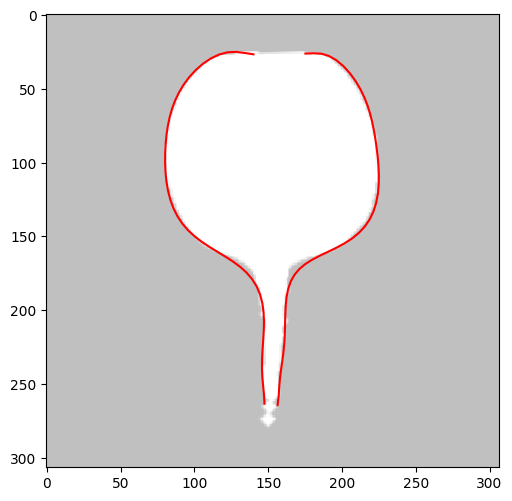

In [28]:
%%time
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=10,samples=cntL)
bezR = rd.BezierCurve(N=10,samples=cntR)
# BezierCurve.toggledebugmode(set=True,debug=True)
# 高速あてはめの実行
cpsL,fL = bezL.fit0()
cpsR,fR = bezR.fit0()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL,bezR=fR)

## 得られたベジエ曲線の定義式

In [29]:
fL,fR

(Matrix([
 [147.0*t**10 + 152.457566212441*t**9*(-10*t + 10) + 5248.69037958959*t**8*(-t + 1)**2 + 20682.2664308067*t**7*(-t + 1)**3 + 63910.2808949522*t**6*(-t + 1)**4 - 81542.4517079827*t**5*(-t + 1)**5 + 89021.6849298554*t**4*(-t + 1)**6 - 13724.3176722564*t**3*(-t + 1)**7 + 5891.23479731429*t**2*(-t + 1)**8 + 1080.61593974049*t*(-t + 1)**9 + 147.0*(-t + 1)**10],
 [ 270.0*t**10 + 236.968763233282*t**9*(-10*t + 10) + 8976.58406504399*t**8*(-t + 1)**2 + 33065.5911134046*t**7*(-t + 1)**3 - 47887.2057841463*t**6*(-t + 1)**4 + 196550.533180098*t**5*(-t + 1)**5 - 95808.7268723942*t**4*(-t + 1)**6 + 48197.5896263449*t**3*(-t + 1)**7 - 3699.90722088303*t**2*(-t + 1)**8 + 380.489704736135*t*(-t + 1)**9 + 26.0*(-t + 1)**10]]),
 Matrix([
 [154.0*t**10 + 173.847410083026*t**9*(-10*t + 10) + 3513.84295150364*t**8*(-t + 1)**2 + 56998.2213972449*t**7*(-t + 1)**3 - 117661.899501746*t**6*(-t + 1)**4 + 288266.329931095*t**5*(-t + 1)**5 - 84582.7704331223*t**4*(-t + 1)**6 + 60945.1710166222*t**3*(-t +

## 制御点

In [30]:
["({:5.2f},{:5.2f})".format(x[0][0],x[1][0]) for x in cpsL],["({:5.2f},{:5.2f})".format(x[0][0],x[1][0]) for x in cpsR]

(['(147.00,26.00)',
  '(108.06,38.05)',
  '(130.92,-82.22)',
  '(-114.37,401.65)',
  '(423.91,-456.23)',
  '(-323.58,779.96)',
  '(304.33,-228.03)',
  '(172.35,275.55)',
  '(116.64,199.48)',
  '(152.46,236.97)',
  '(147.00,270.00)'],
 ['(168.00,25.00)',
  '(211.15,39.29)',
  '(154.66,-80.44)',
  '(507.88,493.31)',
  '(-402.78,-654.27)',
  '(1143.91,1094.28)',
  '(-560.29,-506.38)',
  '(474.99,429.84)',
  '(78.09,151.34)',
  '(173.85,246.78)',
  '(154.00,270.00)'])

# 厳密フィッティング fit1()の実行例  (!openmode)

..........
..........
CPU times: user 39.9 s, sys: 27.6 ms, total: 39.9 s
Wall time: 40 s


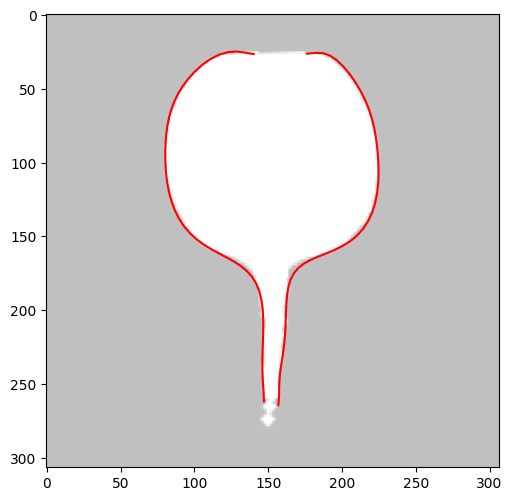

In [31]:
%%time
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
# cntL = rd.getSamples(conLeft,N=32)
# cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
# bezL = rd.BezierCurve(N=10,samples=cntL)
# bezR = rd.BezierCurve(N=10,samples=cntR)
# BezierCurve.toggledebugmode(set=True,debug=True)
# ここまでは前にやったので流用
# 厳密あてはめ
cpsL1,fL1 = bezL.fit1()
cpsR1,fR1 = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL1,bezR=fR1)

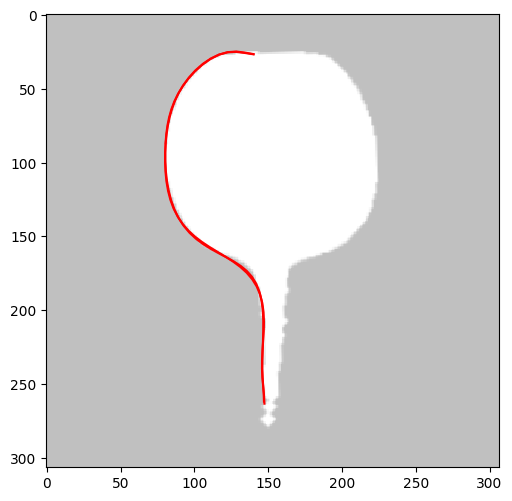

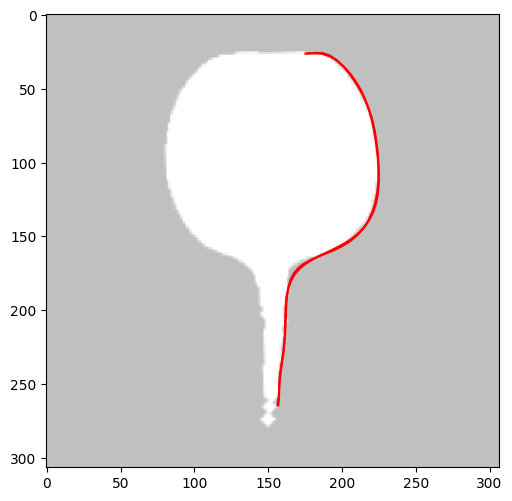

In [32]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL,bezR=fL1)
rd.drawBez(img,stt=0.02,end=0.98,bezL=fR1,bezR=fR)

fit0 の結果と fit1 の結果を重ねて描いてみたが、目視ではほとんど違いはない。

In [33]:
fL,fL1,fR,fR1

(Matrix([
 [147.0*t**10 + 152.457566212441*t**9*(-10*t + 10) + 5248.69037958959*t**8*(-t + 1)**2 + 20682.2664308067*t**7*(-t + 1)**3 + 63910.2808949522*t**6*(-t + 1)**4 - 81542.4517079827*t**5*(-t + 1)**5 + 89021.6849298554*t**4*(-t + 1)**6 - 13724.3176722564*t**3*(-t + 1)**7 + 5891.23479731429*t**2*(-t + 1)**8 + 1080.61593974049*t*(-t + 1)**9 + 147.0*(-t + 1)**10],
 [ 270.0*t**10 + 236.968763233282*t**9*(-10*t + 10) + 8976.58406504399*t**8*(-t + 1)**2 + 33065.5911134046*t**7*(-t + 1)**3 - 47887.2057841463*t**6*(-t + 1)**4 + 196550.533180098*t**5*(-t + 1)**5 - 95808.7268723942*t**4*(-t + 1)**6 + 48197.5896263449*t**3*(-t + 1)**7 - 3699.90722088303*t**2*(-t + 1)**8 + 380.489704736135*t*(-t + 1)**9 + 26.0*(-t + 1)**10]]),
 [147.0*t**10 + 148.637943949366*t**9*(-10*t + 10) + 6266.38710596183*t**8*(-t + 1)**2 + 13364.0443940985*t**7*(-t + 1)**3 + 82313.4774430682*t**6*(-t + 1)**4 - 100480.199806359*t**5*(-t + 1)**5 + 99020.2949100151*t**4*(-t + 1)**6 - 16129.9807890305*t**3*(-t + 1)**7 + 6

# Openmode
上の結果は両端の制御点としてサンプルの両端を用いることで、２組の制御点の計算を省いている。

**Openmode** は両端の制御点もフィッティングの未知数として扱う。

In [34]:
rd.BezierCurve.setParameters(openmode=True)

driftThres:  0.03
errorThres:  0.01
dCount    :  5
debugmode :  False
openmode  :  True



..
..


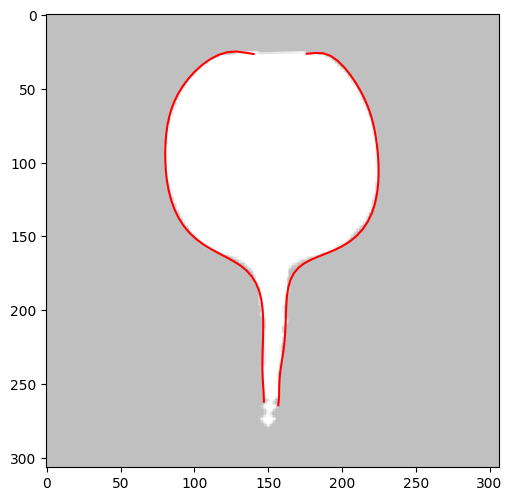

In [35]:
# 厳密あてはめ
cpsL1,fL2 = bezL.fit1()
cpsR1,fR2 = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL2,bezR=fR2)

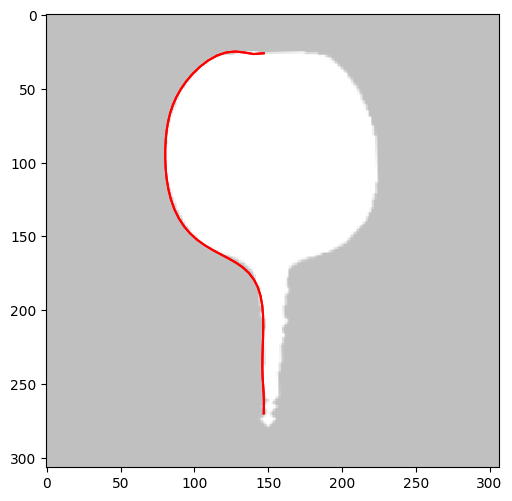

In [36]:
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL1,bezR=fL2)

In [37]:
fL1,fL2,fR1,fR2

([147.0*t**10 + 148.637943949366*t**9*(-10*t + 10) + 6266.38710596183*t**8*(-t + 1)**2 + 13364.0443940985*t**7*(-t + 1)**3 + 82313.4774430682*t**6*(-t + 1)**4 - 100480.199806359*t**5*(-t + 1)**5 + 99020.2949100151*t**4*(-t + 1)**6 - 16129.9807890305*t**3*(-t + 1)**7 + 6002.94461564793*t**2*(-t + 1)**8 + 1084.63391612946*t*(-t + 1)**9 + 147.0*(-t + 1)**10,
  270.0*t**10 + 223.022476056464*t**9*(-10*t + 10) + 12000.4603921458*t**8*(-t + 1)**2 + 16716.2852209616*t**7*(-t + 1)**3 - 23055.3747419372*t**6*(-t + 1)**4 + 193395.972557981*t**5*(-t + 1)**5 - 106520.383287274*t**4*(-t + 1)**6 + 52280.9930160516*t**3*(-t + 1)**7 - 3930.19628441616*t**2*(-t + 1)**8 + 374.415447286045*t*(-t + 1)**9 + 26.0*(-t + 1)**10],
 [146.984299379705*t**10 + 148.559926359028*t**9*(-10*t + 10) + 6269.27684784861*t**8*(-t + 1)**2 + 13672.6064742912*t**7*(-t + 1)**3 + 79911.6947569078*t**6*(-t + 1)**4 - 95237.9776505989*t**5*(-t + 1)**5 + 94642.1476057*t**4*(-t + 1)**6 - 14586.9045853697*t**3*(-t + 1)**7 + 5799.42

.
.


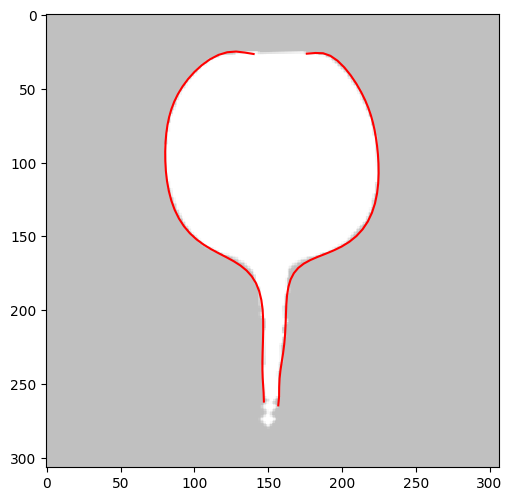

In [38]:
# 厳密あてはめ

cpsL1,fL2 = bezL.fit1()
cpsR1,fR2 = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL2,bezR=fR2)

# 低次の近似　openmode

In [39]:
bezL4 = rd.BezierCurve(N=4,samples=cntL)
bezR4 = rd.BezierCurve(N=4,samples=cntR)
cpsL4,fL4 = bezL4.fit1()
cpsR4,fR4 = bezR4.fit1()



........................
........................


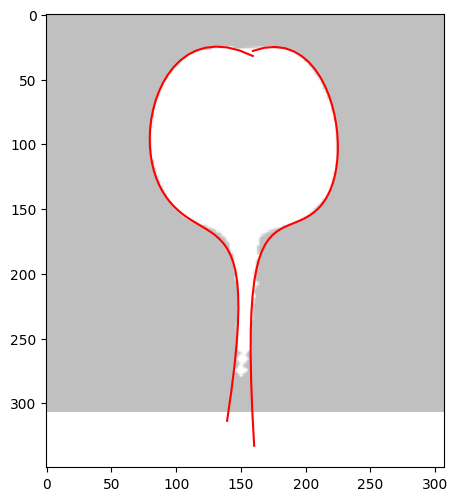

In [40]:
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL4,bezR=fR4)

## 非 openmode

In [41]:
rd.BezierCurve.setParameters(openmode=False)
cpsL4,fL4 = bezL4.fit1()
cpsR4,fR4 = bezR4.fit1()


driftThres:  0.03
errorThres:  0.01
dCount    :  5
debugmode :  False
openmode  :  False

.........................
.....................


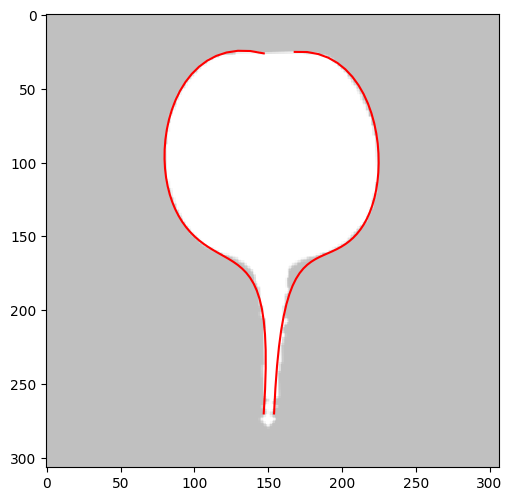

In [42]:
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL4,bezR=fR4)

これは４次のベジエ曲線だが、そこそこ近似できている

非オープンモードで３次



.............
...............


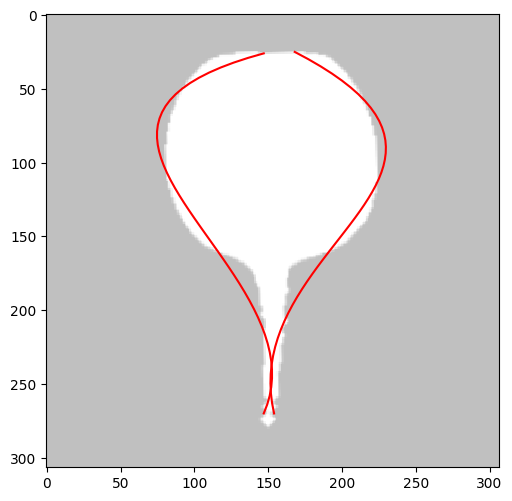

In [43]:
bezL3 = rd.BezierCurve(N=3,samples=cntL)
bezR3 = rd.BezierCurve(N=3,samples=cntR)
cpsL3,fL3 = bezL3.fit1()
cpsR3,fR3 = bezR3.fit1()
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL3,bezR=fR3)

### openmode で３次

driftThres:  0.03
errorThres:  0.01
dCount    :  5
debugmode :  False
openmode  :  True



..............
..................


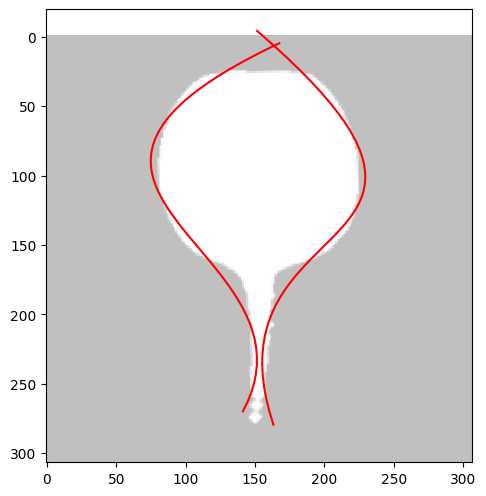

In [44]:
rd.BezierCurve.setParameters(openmode=True)
bezL3 = rd.BezierCurve(N=3,samples=cntL)
bezR3 = rd.BezierCurve(N=3,samples=cntR)
cpsL3,fL3 = bezL3.fit1()
cpsR3,fR3 = bezR3.fit1()
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL3,bezR=fR3)

## openmode、３次、高速

driftThres:  0.03
errorThres:  0.01
dCount    :  5
debugmode :  False
openmode  :  True





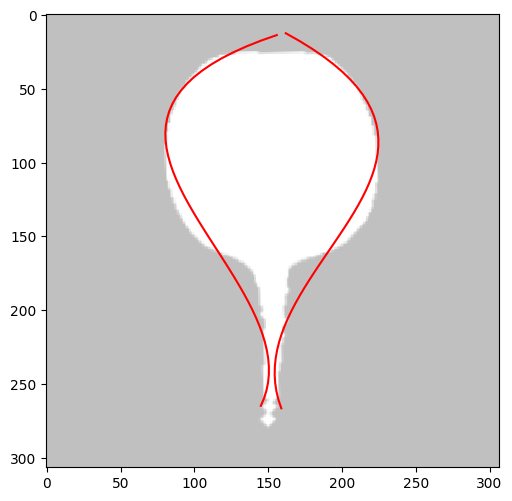

In [45]:
rd.BezierCurve.setParameters(openmode=True)
bezL3 = rd.BezierCurve(N=3,samples=cntL)
bezR3 = rd.BezierCurve(N=3,samples=cntR)
cpsL3,fL3 = bezL3.fit0()
cpsR3,fR3 = bezR3.fit0()
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL3,bezR=fR3)

# 非 openmode、３次、高速

driftThres:  0.03
errorThres:  0.01
dCount    :  5
debugmode :  False
openmode  :  False





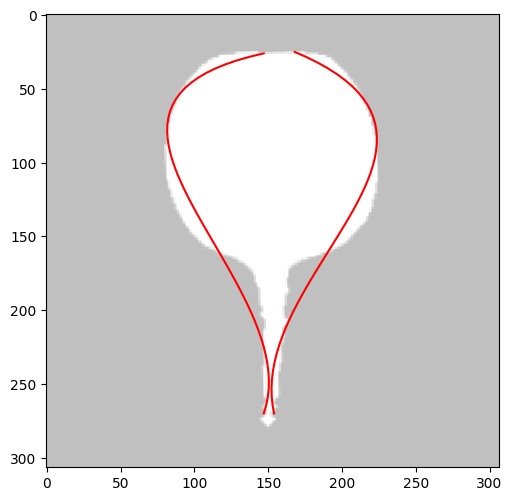

In [47]:
rd.BezierCurve.setParameters(openmode=False)
bezL3 = rd.BezierCurve(N=3,samples=cntL)
bezR3 = rd.BezierCurve(N=3,samples=cntR)
cpsL3,fL3 = bezL3.fit0()
cpsR3,fR3 = bezR3.fit0()
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL3,bezR=fR3)

.............
...............


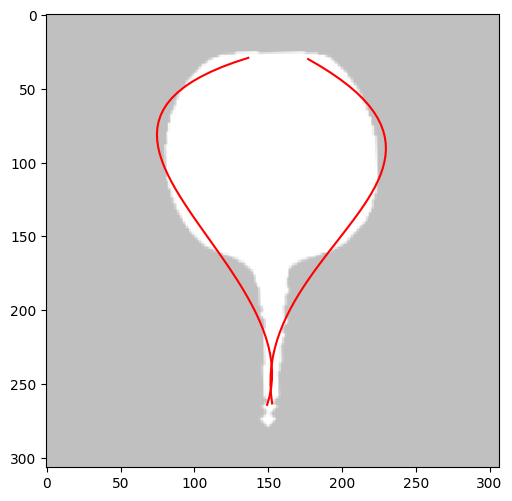

In [49]:
# 厳密あてはめ
cpsL1,fL = bezL3.fit1()
cpsR1,fR = bezR3.fit1()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL,bezR=fR)